
We first define a Sample class which will hold the sample values


In [ ]:
import random
import math

class Sample():
    def __init__(self, attributes: dict, outcome):
        self.attributes = attributes
        self.outcome = outcome
    
    def size(self):
        return self.attributes.size

    def __str__(self):
        return self.outcome + " : " + str(self.attributes) 

Then we define the main class representing the Decision Tree. It's a simple N-Tree implementation.
Each node is defined by:
*   The argument it will split on
*   The result of the majority voting in that node
*   Its children, which are saved through a dictionary with keys the possible values of the split argument



In [ ]:
class DecisionTree():
    def __init__(self, samples, attributes, parent_sample=None):
        self.childs = {}
        self.split_arg = None
        self.result = None

        self.learn(samples, parent_sample, attributes)
    
    def learn(self, samples, parent_sample, attributes):
        #print("Node of tree with " + str(len(samples)) + " samples and attributes: " + str(attributes))
        if not samples:
            self.result = self.majority_voting(parent_sample)
            return
        if self.uniform_outcome(samples):
            self.result =  samples[0].outcome
            return
        if not attributes:
            self.result =  self.majority_voting(samples)
            return

        self.result = self.majority_voting(samples)
        self.split_arg = self.important(samples, attributes)
        #print("Picked arg: " + self.split_arg)
        attributes.remove(self.split_arg)
        classes = self.split(self.split_arg, samples)
        for c in classes.keys():
            self.childs[c] = DecisionTree(classes[c], attributes.copy(), samples)

    def __str__(self):
        return self.repr(0) 

    def repr(self, level):
        res = '\t'*level 
        if self.split_arg != None:
            res += str(self.split_arg)+ ": " + str(self.childs.keys()) 
        else:
            res += self.result
            
        res += '\n'
        for c in self.childs.values():
            if c:
                res+=c.repr(level+1)
        return str(res)

    def guess(self, sample):
        if self.split_arg == None:
            return self.result

        value = sample.attributes[self.split_arg]

        if value not in self.childs.keys():
            return self.result

        return self.childs[value].guess(sample)

    def visualize(self, parent = None, split_value = ""):
        if (self.split_arg is None):
            return WNode( self.result, parent, weight=split_value )
        this = WNode(self.split_arg +"?", parent, weight=split_value)
        
        for c in self.childs.keys():
            self.childs[c].visualize(this, c)
        return this

    @staticmethod
    def majority_voting(samples):
        maj = {}
        for p in samples:
            if p.outcome in maj:
                maj[p.outcome] += 1
            else:
                maj[p.outcome] = 1
        
        res= (None, 0)
        for m in maj.keys():
            if res[1] < maj[m]:
                res = (m, maj[m])

        return res[0] 

    @staticmethod
    def split(attr, samples):
        classes = {}
        for s in samples:
            if s.attributes[attr] not in classes:
                classes[s.attributes[attr]] = []
            classes[s.attributes[attr]].append(s)
        
        return classes

    @staticmethod
    def uniform_outcome(samples):
        outcome = samples[0].outcome
        for s in samples:
            if outcome != s.outcome:
                return False
        return True

    @staticmethod
    def information_gain(samples, splitter):
        subsets = DecisionTree.split(splitter, samples)
        p,n = DecisionTree.count_p_n(samples)

        return DecisionTree.entropy(p, n) - DecisionTree.remainder(subsets, p, n)

    @staticmethod
    def remainder(subsets, p, n):
        tot = 0
        for s in subsets.values():
            pk, nk = DecisionTree.count_p_n(s)
            tot += (pk+nk)/(p+n)*DecisionTree.entropy(pk, nk)
        return tot    

    @staticmethod
    def entropy( p, n):
        q = p/(p+n)
        if (q==0 or q==1):
            return 0
        else :
            return -(q * math.log2(q) + (1-q)* math.log2(1-q))

    @staticmethod
    def count_p_n(samples):
        p = 0
        for s in samples:
            # print(s)
            if (s.outcome == "Yes"):
                p+=1
        n = len(samples) - p
        return p, n

    @staticmethod
    def important(samples, attributes):
        max_gain = 0
        max_attr = None
        for a in attributes:
            attr_gain = DecisionTree.information_gain(samples, a)
            if (attr_gain>max_gain):
                max_gain=attr_gain
                max_attr = a
        return max_attr


Then we define some utility functions for inputting and outputting samples and results of guessing


In [ ]:
def read_input(filename) :
    f = open(filename, "r")
    lines = f.readlines()
    head = lines.pop(0).split(',')
    f.close()


    attributes = []
    for a in head:
        attributes.append(a)
    attributes.pop()

    samples= []
    for l in lines:
        el = {}
        values = l.split(',')
        for a in range(len(values)-1):
            el[attributes[a]] = values[a]

        samples.append(Sample(el, values[-1].replace("\n", "")))
    return samples, attributes

Finally we execute our code. We first input our samples:

In [ ]:
samples, attributes = read_input("/content/sample_data/learning_set.csv")

FileNotFoundError: ignored

then we construct our tree

In [ ]:
DT = DecisionTree(samples=samples, attributes=attributes)

We can also visualize the tree through the help of some libraries

Pat? (None)
├── Yes (Some)
├── Hun? (Full)
│   ├── Type? (Yes)
│   │   ├── Fri? (Thai)
│   │   │   ├── No (No)
│   │   │   └── Yes (Yes)
│   │   ├── No (Italian)
│   │   └── Yes (Burger)
│   └── No (No)
└── No (None)


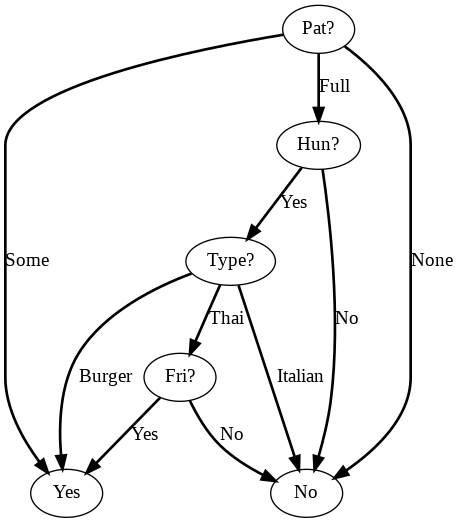

In [ ]:
!pip install anytree
import anytree as Tree
from anytree.exporter import DotExporter
from anytree import NodeMixin, RenderTree

class WNode(NodeMixin):
    def __init__(self, label, parent=None, weight=None):
        super(WNode, self).__init__()
        self.label = label
        self.parent = parent
        self.weight = weight if parent is not None else None
    def _post_detach(self, parent):
        self.weight = None


for pre, fill, node in Tree.RenderTree(DT.visualize()):
    print("%s%s (%s)" % (pre, node.label, node.weight))

DotExporter(DT.visualize(),
            nodenamefunc=lambda node: node.label,
            edgeattrfunc=lambda parent, child: "style=bold,label=%s" % (child.weight or 0)
).to_picture("/content/decision_tree.png") 

from IPython.display import Image
Image(filename="/content/decision_tree.png") 

in the end we can test our DT, first on the learning set

Note: if performance is lower than 100% something went wrong.

In [ ]:
def test(decision_tree, samples):
    score = 0
    for sample in samples:
        guessed = decision_tree.guess(sample)
        if (guessed == sample.outcome):
            score+=1
        else:
            print(f"On sample {sample.attributes} with outcome {sample.outcome} the decision Tree guessed: {guessed}")
    return score
print(f"On learning set DT performance is { test(DT,samples) } / { len(samples) }")


On learning set DT performance is 12 / 12


Then on the test set:


In [ ]:
samples, attributes = read_input("/content/sample_data/test_set.csv")
print(f"On test set DT performance is { test(DT,samples) } / { len(samples) }")

On sample {'Alt': 'Yes', 'Bar': 'No', 'Fri': 'No', 'Hun': 'Yes', 'Pat': 'Full', 'Price': '$$$', 'Rain': 'No', 'Res': 'Yes', 'Type': 'French', 'Est': '0-10'} with outcome Yes the decision Tree guessed: No
On test set DT performance is 0 / 1


# Dataset piú complessi


By modifying the Tree class:

In [ ]:
class DecisionTree():
    def __init__(self, samples, attributes, parent_sample=None):
        self.childs = {}
        self.split_arg = None
        self.result = None

        self.learn(samples, parent_sample, attributes)
    
    def learn(self, samples, parent_sample, attributes):
        #print("Node of tree with " + str(len(samples)) + " samples and attributes: " + str(attributes))
        if not samples:
            self.result = self.majority_voting(parent_sample)
            return
        if self.uniform_outcome(samples):
            self.result =  samples[0].outcome
            return
        if not attributes:
            self.result =  self.majority_voting(samples)
            return

        self.result = self.majority_voting(samples)
        self.split_arg = self.important(samples, attributes)
        #print("Picked arg: " + self.split_arg)
        attributes.remove(self.split_arg)
        classes = self.split(self.split_arg, samples)
        for c in classes.keys():
            self.childs[c] = DecisionTree(classes[c], attributes.copy(), samples)

    def __str__(self):
        return self.repr(0) 

    def repr(self, level):
        res = '\t'*level 
        if self.split_arg != None:
            res += str(self.split_arg)+ ": " + str(self.childs.keys()) 
        else:
            res += self.result
            
        res += '\n'
        for c in self.childs.values():
            if c:
                res+=c.repr(level+1)
        return str(res)

    def guess(self, sample):
        if self.split_arg == None:
            return self.result

        value = sample.attributes[self.split_arg]

        if value not in self.childs.keys():
            return self.result

        return self.childs[value].guess(sample)

    def visualize(self, parent = None, split_value = ""):
        if (self.split_arg is None):
            return WNode( self.result, parent, weight=split_value )
        this = WNode(self.split_arg +"?", parent, weight=split_value)
        
        for c in self.childs.keys():
            self.childs[c].visualize(this, c)
        return this

    @staticmethod
    def majority_voting(samples):
        maj = {}
        for p in samples:
            if p.outcome in maj:
                maj[p.outcome] += 1
            else:
                maj[p.outcome] = 1
        
        res= (None, 0)
        for m in maj.keys():
            if res[1] < maj[m]:
                res = (m, maj[m])

        return res[0] 

    @staticmethod
    def split(attr, samples):
        classes = {}
        for s in samples:
            if s.attributes[attr] not in classes:
                classes[s.attributes[attr]] = []
            classes[s.attributes[attr]].append(s)
        
        return classes

    @staticmethod
    def uniform_outcome(samples):
        outcome = samples[0].outcome
        for s in samples:
            if outcome != s.outcome:
                return False
        return True

    @staticmethod
    def information_gain(samples, splitter):
        subsets = DecisionTree.split(splitter, samples)
        p,n = DecisionTree.count_p_n(samples)

        return DecisionTree.entropy(p, n) - DecisionTree.remainder(subsets, p, n)

    @staticmethod
    def remainder(subsets, p, n):
        tot = 0
        for s in subsets.values():
            pk, nk = DecisionTree.count_p_n(s)
            tot += (pk+nk)/(p+n)*DecisionTree.entropy(pk, nk)
        return tot    

    @staticmethod
    def entropy( p, n):
        q = p/(p+n)
        if (q==0 or q==1):
            return 0
        else :
            return -(q * math.log2(q) + (1-q)* math.log2(1-q))

    @staticmethod
    def count_p_n(samples):
        p = 0
        for s in samples:
            # print(s)
            if (s.outcome == "Yes"):
                p+=1
        n = len(samples) - p
        return p, n

    @staticmethod
    def important(samples, attributes):
        max_gain = 0
        max_attr = None
        for a in attributes:
            attr_gain = DecisionTree.information_gain(samples, a)
            if (attr_gain>max_gain):
                max_gain=attr_gain
                max_attr = a
        return max_attr
